**Question 1**

In [94]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import os
from pandas import Series, DataFrame

# def open_files():
#     directory = '/Users/piper/Piper Documents/R and Python/Project 2/DataRaw/Diabetes-Data/'
#     with open ('/Users/piper/Piper Documents/R and Python/Project 2/DataRaw/Diabetes-Data/all_data.txt', 'w') as output_file:
#         for data_file in os.listdir(directory):
#             if data_file != '.DS_Store':
#                 print('reading from ' + data_file)
#                 input_file_path = os.path.join(directory, data_file)            
#                 with open (input_file_path) as input_file:
#                     line = input_file.readline().strip()
#                     while line:
#                         output_line = line + '\t' + str(data_file) + '\n'
#                         output_file.write(output_line)
#                         line = input_file.readline().strip()
#                     input_file.close()
#         output_file.close()

# if __name__ == "__main__":
#     print('main')
#     open_files()
    

In [15]:
# read-in data
data = pd.read_csv('/Users/piper/Piper Documents/R and Python/Project 2/DataRaw/Diabetes-Data/all_data.txt', 
                   sep = '\t', header = None)
data_final = DataFrame(data)
data_final.columns = ['date', 'time', 'code', 'value', 'id']
data_final.shape

(29330, 5)

In [16]:
# exlude data anomalies in data-29 and data-27
data_final = data_final[(data_final[['date', 'time', 'code', 'value']] !='data-29' ).all(axis=1)]
data_final = data_final[(data_final[['date', 'time', 'code', 'value']] !='data-27' ).all(axis=1)]
data_final.shape

(29264, 5)

In [17]:
# exclude rows with non-numerical values, total rows excluded = 8
data_final = data_final[(data_final[['date', 'time', 'code', 'value']] !='0Hi' ).all(axis=1)]
data_final = data_final[(data_final[['date', 'time', 'code', 'value']] !='0Lo' ).all(axis=1)]
data_final = data_final[(data_final[['date', 'time', 'code', 'value']] !="0''" ).all(axis=1)]
data_final.shape

(29256, 5)

In [18]:
# prep data for future project questions
# subset times into 'Part of Day' variable
string = data_final['time'].str.split(':', n = 1, expand = True) 
data_final['hour'] = pd.to_numeric(string[0])
data_final['minutes'] = pd.to_numeric(string[1])
data_final['total_minutes'] = data_final['hour']*60 + data_final['minutes']
data_final.head()

,date,time,code,value,id,hour,minutes,total_minutes
0,05-20-1991,08:00,58,101,data-31,8,0,480
1,05-20-1991,08:00,33,005,data-31,8,0,480
2,05-20-1991,08:00,34,027,data-31,8,0,480
3,05-20-1991,12:00,60,089,data-31,12,0,720
4,05-20-1991,12:00,33,003,data-31,12,0,720


In [19]:
# create 'Part-of-Day' variable
bins = [0, ((11*60) + 59), ((16*60) + 59), ((24*60))]
labels = ['Morning', 'Afternoon', 'Evening']
data_final['part_of_day'] = pd.cut(data_final['total_minutes'], bins=bins, labels=labels, include_lowest=True)
data_final.head()

,date,time,code,value,id,hour,minutes,total_minutes,part_of_day
0,05-20-1991,08:00,58,101,data-31,8,0,480,Morning
1,05-20-1991,08:00,33,005,data-31,8,0,480,Morning
2,05-20-1991,08:00,34,027,data-31,8,0,480,Morning
3,05-20-1991,12:00,60,089,data-31,12,0,720,Afternoon
4,05-20-1991,12:00,33,003,data-31,12,0,720,Afternoon


In [20]:
data_final.isnull().sum(axis = 0) # realize there are 5 NaN's for part_of_day recorded times

date             0
time             0
code             0
value            0
id               0
hour             0
minutes          0
total_minutes    0
part_of_day      5
dtype: int64

In [21]:
data_final.sort_values(by=['hour'], ascending=False).head() # can see the inaccurately recorded times here

,date,time,code,value,id,hour,minutes,total_minutes,part_of_day
17982,04-21-1991,188:00,62,128,data-67,188,0,11280,NaN
17983,04-21-1991,188:00,33,014,data-67,188,0,11280,NaN
17882,04-09-1991,56:35,33,016,data-67,56,35,3395,NaN
17883,04-09-1991,56:35,34,040,data-67,56,35,3395,NaN
17881,04-09-1991,56:35,58,237,data-67,56,35,3395,NaN


In [22]:
# drop NaN's, no. of rows with NaN's = 5
data_final = data_final.dropna(axis = 0)
data_final.shape # worked

(29251, 9)

In [23]:
# convert 'value' column to numeric
data_final['value'] = data_final.value.astype('float')
data_final.head()

,date,time,code,value,id,hour,minutes,total_minutes,part_of_day
0,05-20-1991,08:00,58,101.0,data-31,8,0,480,Morning
1,05-20-1991,08:00,33,5.0,data-31,8,0,480,Morning
2,05-20-1991,08:00,34,27.0,data-31,8,0,480,Morning
3,05-20-1991,12:00,60,89.0,data-31,12,0,720,Afternoon
4,05-20-1991,12:00,33,3.0,data-31,12,0,720,Afternoon


In [24]:
# delete uneeded columns
data_final.drop(['hour', 'minutes', 'total_minutes'], axis = 1, inplace = True)

**Question 2**

In [36]:
# include only codes 58-63, glucose measurement codes
df_2 = data_final.loc[data_final['code'].isin(['58','59','60','61','62','63'])]
df_2 = df_2[['date', 'code', 'value']]
df_2.shape

(9747, 3)

In [37]:
# realized that there were 3 data points that indicated records were taken around year 1675, exclude from analyses
df_2['Date'] = pd.to_datetime(df_2['date'], errors = 'coerce')
df_2.drop(['date'], axis = 1, inplace = True)
df_2 = df_2[(df_2['Date'] > '1950-01-01') & (df_2['Date'] < '2010-01-01')]
df_2.shape # dropped 3 outlier dates recorded

(9744, 3)

In [38]:
# obtain the median glucose, 25th percentiles, and 75th percentiles for each code
group_2 = df_2.groupby(['code'])
median = group_2.quantile(0.5)
low_p = group_2.quantile(0.25)
high_p = group_2.quantile(0.75)

In [42]:
# summarize in table below
table_2 = pd.concat([median, low_p, high_p], axis=1)
table_2.columns = ['Median Glucose', '25th','75th']
table_2['IQR'] = '(' + table_2['25th'].astype(str) + ', ' + table_2['75th'].astype(str) + ')'
table_2.drop(['25th', '75th'], axis = 1, inplace = True)

# change indices so I know what the code is refering to
table_2.rename(index = {'58':'Pre-Breakfast', '59':'Post-Breakfast', '60':'Pre-Lunch', 
                        '61':'Post-Lunch', '62':'Pre-Dinner', '63':'Post-Dinner'}, inplace = True)
del table_2.index.name
table_2

,Median Glucose,IQR
Pre-Breakfast,161.0,"(107.75, 223.0)"
Post-Breakfast,190.5,"(87.0, 230.0)"
Pre-Lunch,134.0,"(85.0, 187.0)"
Post-Lunch,225.0,"(177.0, 303.5)"
Pre-Dinner,147.0,"(99.0, 201.0)"
Post-Dinner,183.0,"(104.0, 257.0)"


**Question 3**

In [43]:
criteria = data_final.loc[data_final['code'].isin(['65','66','67','68','69','70','71','72'])].index
df_3 = data_final.loc[criteria, :]
group_3 = df_3.groupby(['id', 'code', 'part_of_day']).size().reset_index(name='freq')
group_3['indicator'] = 1
group_3.drop(['freq'], axis = 1, inplace = True)
group_3.head() #357 x 4, indicator means that patient had at least one recording of a specific code at that time

,id,code,part_of_day,indicator
0,data-01,65,Morning,1
1,data-01,65,Afternoon,1
2,data-01,65,Evening,1
3,data-03,65,Morning,1
4,data-03,65,Afternoon,1


In [45]:
# table that sums up number of patients who had at least one recording of the codes specified at given part-of-day
table_3 = pd.crosstab(group_3['code'], group_3['part_of_day'])

# change indices to know what code is refering to
table_3.rename(index = {'65':'Hypoglycemic Symptoms', '66':'Typical Meal Ingestion', 
                        '67':'More-than-Usual Meal Ingestion', 
                        '68':'Less-than-Usual Meal Ingestion', 
                        '69':'Typical Exercise Activity', 
                        '70':'More-than-Usual Exercise Activity',
                        '71':'Less-than-Usual Exercise Activity', 
                        '72':'Unspecified Special Event'}, inplace = True)
table_3 = table_3.rename_axis('').rename_axis('', axis = 1)
table_3

,Morning,Afternoon,Evening
,,,
Hypoglycemic Symptoms,31,20,22
Typical Meal Ingestion,11,9,8
More-than-Usual Meal Ingestion,30,15,32
Less-than-Usual Meal Ingestion,9,7,6
Typical Exercise Activity,10,6,14
More-than-Usual Exercise Activity,12,10,21
Less-than-Usual Exercise Activity,9,11,16
Unspecified Special Event,24,11,13


In [46]:
# divide each cell by 70 to get proportions, also round to two decimal places
table_3b = round((table_3/70)*100, 2)
table_3b

,Morning,Afternoon,Evening
,,,
Hypoglycemic Symptoms,44.29,28.57,31.43
Typical Meal Ingestion,15.71,12.86,11.43
More-than-Usual Meal Ingestion,42.86,21.43,45.71
Less-than-Usual Meal Ingestion,12.86,10.00,8.57
Typical Exercise Activity,14.29,8.57,20.00
More-than-Usual Exercise Activity,17.14,14.29,30.00
Less-than-Usual Exercise Activity,12.86,15.71,22.86
Unspecified Special Event,34.29,15.71,18.57


**Question 4**

In [47]:
criteria = data_final.loc[data_final['code'].isin(['33', '34', '35'])].index
df_4 = data_final.loc[criteria, :]
df_4.head()

,date,time,code,value,id,part_of_day
1,05-20-1991,08:00,33,5.0,data-31,Morning
2,05-20-1991,08:00,34,27.0,data-31,Morning
4,05-20-1991,12:00,33,3.0,data-31,Afternoon
6,05-20-1991,18:00,33,6.0,data-31,Evening
9,05-21-1991,08:00,33,5.0,data-31,Morning


In [48]:
# for patients with more than one dose of insulin of given type within certain part-of-day, sum doses
group_4 = df_4.groupby(['id', 'date', 'code', 'part_of_day'])[['value']].sum() 
# some patients did not have recorded data at certain parts of the day, leading to NaN's

# drop these NaN's
group_4 = group_4.dropna()

# reset index
group_4 = group_4.reset_index()

# change indices to know what codes are refering to
group_4['type'] = group_4['code'].replace({'33': 'Regular', '34': 'NPH', '35': 'UltraLente'})
group_4.drop(['code'], axis = 1, inplace = True)
group_4.head()

,id,date,part_of_day,value,type
0,data-01,04-21-1991,Morning,9.0,Regular
1,data-01,04-21-1991,Evening,7.0,Regular
2,data-01,04-21-1991,Morning,13.0,NPH
3,data-01,04-22-1991,Morning,10.0,Regular
4,data-01,04-22-1991,Afternoon,9.0,Regular


In [49]:
# exclude outliers, some extremely large insulin dosage values
group_4 = group_4.loc[group_4['value'] < 50, :] 

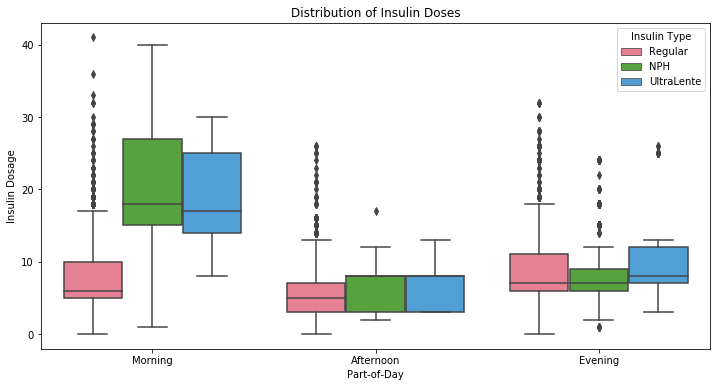

In [50]:
# boxplot by insulin type and part-of-day
plt.figure(figsize=(12,6))
sns.boxplot(x='part_of_day', y='value', hue='type', data=group_4, palette='husl')
plt.title('Distribution of Insulin Doses')
plt.ylabel('Insulin Dosage')
plt.xlabel('Part-of-Day')
plt.legend(title = 'Insulin Type')
plt.show()

**Question 5**

In [97]:
criteria = data_final.loc[data_final['code'].isin(['58','59','60','61','62','63'])].index
df_5 = data_final.loc[criteria, :]
df_5['Date'] = pd.to_datetime(df_5['date'], errors = 'coerce')
df_5['time'] = [x + ':00' for x in df_5['time']]
df_5['Time'] = pd.to_timedelta(df_5['time'].astype(str))

# get datetime variable for plotting purposes
df_5['datetime'] = pd.to_datetime(df_5['Date']+df_5['Time'])
df_5 = df_5.set_index('datetime')

# drop unneeded variables
df_5.drop(['date', 'time', 'Date', 'Time'], axis = 1, inplace = True)

# also, drop 3 data points with outlier recorded years
df_5 = df_5.loc['1950-01-01 00:00:00':'2010-01-01 00:00:00']
df_5.head()

,code,value,id,part_of_day
datetime,,,,
1991-05-20 08:00:00,58,101.0,data-31,Morning
1991-05-20 12:00:00,60,89.0,data-31,Afternoon
1991-05-20 18:00:00,62,94.0,data-31,Evening
1991-05-21 08:00:00,58,174.0,data-31,Morning
1991-05-21 12:00:00,60,148.0,data-31,Afternoon


In [98]:
# create pre-post variable
df_5['pre_post'] = ['Pre' if x == '58' or x == '60' or x == '62' else 'Post' for x in df_5['code']]

In [99]:
# create data subsets for pre and post-breakfast, lunch, & dinner
df_5_b = df_5.loc[df_5['code'].isin(['58', '59'])]
df_5_b_pre = df_5_b.loc[df_5_b['pre_post'].isin(['Pre'])]
df_5_b_post = df_5_b.loc[df_5_b['pre_post'].isin(['Post'])]

df_5_l = df_5.loc[df_5['code'].isin(['60', '61'])]
df_5_l_pre = df_5_l.loc[df_5_l['pre_post'].isin(['Pre'])]
df_5_l_post = df_5_l.loc[df_5_l['pre_post'].isin(['Post'])]

df_5_d = df_5.loc[df_5['code'].isin(['62', '63'])]
df_5_d_pre = df_5_d.loc[df_5_d['pre_post'].isin(['Pre'])]
df_5_d_post = df_5_d.loc[df_5_d['pre_post'].isin(['Post'])]

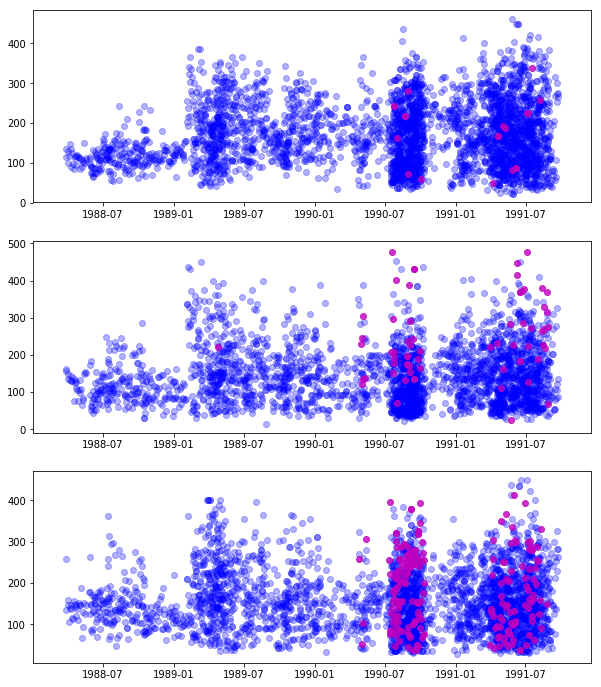

In [109]:
# plot scatterplot of glucose measurement values over time
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (10,12))
ax1.scatter(df_5_b_pre.index, df_5_b_pre.loc[:,'value'], color='b', alpha = 0.3)
ax1.scatter(df_5_b_post.index, df_5_b_post.loc[:,'value'], color='m', alpha = 0.8)

ax2.scatter(df_5_l_pre.index, df_5_l_pre.loc[:,'value'], color='b', alpha = 0.3)
ax2.scatter(df_5_l_post.index, df_5_l_post.loc[:,'value'], color='m', alpha = 0.8)

ax3.scatter(df_5_d_pre.index, df_5_d_pre.loc[:,'value'], color='b', alpha = 0.3)
ax3.scatter(df_5_d_post.index, df_5_d_post.loc[:,'value'], color='m', alpha = 0.8)

plt.show()

In [28]:
# spline fitting, finish


**Question 6**

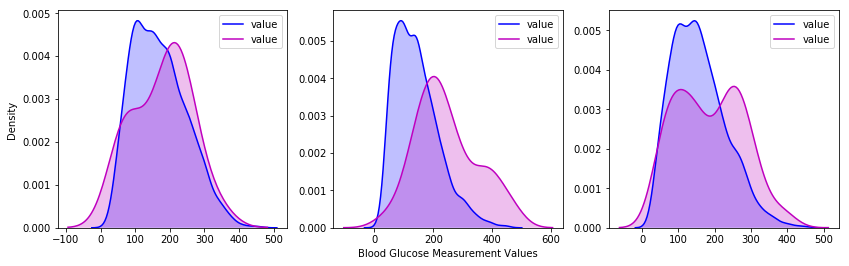

In [145]:
# use same data sets from question 5
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (14,4))

sns.kdeplot(df_5_b_pre['value'], shade=True, color="b", ax=ax1)
sns.kdeplot(df_5_b_post['value'], shade=True, color="m", ax=ax1)
legend = g._legend
legend.set_title("")
for t, l in zip(legend.texts,("Male", "Female")):
    t.set_text(l)

sns.kdeplot(df_5_l_pre['value'], shade=True, color="b", ax=ax2)
sns.kdeplot(df_5_l_post['value'], shade=True, color="m", ax=ax2)

sns.kdeplot(df_5_d_pre['value'], shade=True, color="b", ax=ax3)
sns.kdeplot(df_5_d_post['value'], shade=True, color="m", ax=ax3)

plt.xlabel("Blood Glucose Measurement Values", x=-0.7)
fig.text(0.08, 0.5, "Density", ha="center", va="center", rotation=90)
plt.show()